# Introduction

In this notebook, we'll learn how to **recognize and extract licence plate numbers from car pictures**.

This will allow you to discover, step by step, how you can create the code doing the recognition. In the last part of the workshop, this exact same code will be **packaged to create a service** that you can query from any application!

We will use a **pre-trained model** as it takes a **long time** and **lots of data** to train such a model. However, you'll find the code to train the model as a reference in this repository if you're interested to learn more.

Ready? Let's go!

# Environment initialization

## Libraries
First, we'll need to **install some libraries** that are not part of our container image. Normally, **Red Hat OpenShift Data Science** is already taking care of this for you, based on what it detects in the code. **Red Hat OpenShift Data Science** will reinstall all those libraries for you every time you launch the notebook!

In case you're using this notebook in a different environment, or just to make sure everything is ready, you can run the following cell to install OpenCV (a library to work with images) and Keras (an abstraction layer over Tensorflow).

In [1]:
!pip install opencv-python-headless==4.5.* keras==2.4.*

     |████████████████████████████████| 47.6 MB 24.8 MB/s eta 0:00:01
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


## Imports
Of course, we'll need to import various packages. They are either built in the notebook image you are running, or have been installed in the previous step.

In [2]:
import glob
import json
import os
from os.path import splitext,basename

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

from tensorflow import keras
from tensorflow.keras.models  import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

2021-12-03 22:54:05.807482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Finding Nemo (aka, the plate)...
Now that we have loaded the tools we need, the first step in our journey is to be able to **find a plate within a car picture**.

For us mere humans this may seem easy: it's a rectangle shape with some inscriptions on it, and we pretty much know that it's supposed to be in the front or the rear of the car.

However, when you don't have any understanding of the concept of a rectangle, even less a car, that's something else. Fortunately, we have pre-trained a model to recognize this specific pattern withing a picture (a rectangle shape with some inscriptions).

In this section, we'll see how we can use it to extract this specific part of the image.

## Helper functions
Those are some simple, mostly geometric functions and classes that will be used later on to process the image, resize it, calculate intersections,... Those functions are not really documented.

You can simply run the cell below to initialize those functions.

In [3]:
class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
               # print(label)
                #print(sel_label)
                non_overlap = False
                break
        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels

def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

## Processing functions
Now, the more interesting part. Those are the **main functions** that will be used in our detection pipeline. Each one is executing a step in the process (see comments for each function).

Run the cell below to intialize the functions.

In [4]:
#######################################
# Loads a model given a specific path #
#######################################
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Model Loaded successfully...")
        return model
    except Exception as e:
        print(e)

######################################################################################
# Converts colors from BGR (as read by OpenCV) to RGB (so that we can display them), #
# also eventually resizes the image to fit the size the model has been trained on    #
######################################################################################
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

#########################################################################
# Reconstructs the image from detected pattern into plate cropped image #
#########################################################################
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)
    
    assert final_labels_frontal, "No License plate is founded!"

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor


#####################################################
# Detects a licence plate in an image using a model #
#####################################################
def detect_lp(model, I, max_dim, lp_threshold):
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    return L, TLp, lp_type, Cor

##############################################################################
# Returns the image of the car (vehicle) and the Licence plate image (LpImg) #
##############################################################################
def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor


## Let's make a detection!
Now that we have all our functions ready, we can load our model, and try to detect a licence plate from a test image.

2021-12-03 22:54:16.558338: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-03 22:54:16.558591: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/app-root/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-12-03 22:54:16.558610: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-03 22:54:16.558644: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub-nb-mirkhala): /proc/driver/nvidia/version does not exist
2021-12-03 22:54:16.558827: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the followi

Model Loaded successfully...


2021-12-03 22:54:17.009386: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-03 22:54:17.009971: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


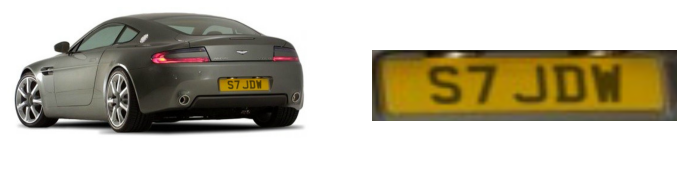

In [5]:
# Load the model
wpod_net_path = "models/wpod-net.json"
wpod_net = load_model(wpod_net_path)

# Get the vehicle image (vehicle) and the plate (LpImg)
test_image_path = "dataset/images/Cars374.png"
vehicle, LpImg, cor = get_plate(test_image_path)

# Display the result
fig = plt.figure(figsize=(12,4))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle);
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0]);

Great, we now know how to detect where the licence plate is located in an image!
We're ready for the next step...

# Recognizing the licence plate number
Now that we have the image of the licence plate itself, we can create new functions to "read" what is written on it. Let's go!

## More processing functions
First, we need to define other functions that will perform the rest of the recognition steps.

In [10]:
######################################################
# Grabs the contour of each digit from left to right #
######################################################
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

###############################################
# Recognizes a single character from an image #
###############################################
def predict_characters_from_model(image):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(character_model.predict(image[np.newaxis,:]))])
    return prediction

####################################################
# Ties all the steps together in a single function #
####################################################
def  lpr_process(input_image_path):
    # Get licence plate image
    vehicle, LpImg, cor = get_plate(input_image_path)
    
    # Preprocess the LP image
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
     # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] #mag threshold adaptativo otsu: punto medio entre dos tonalidades (blanco/negro). 
    # plt.imshow(binary); #mag sale del threshold y los pasa 1 o 0. Lo pasa a 1 canal (RGB: 3 canales). Cada num de la escala de grises y lo pone en 0 ó 1.
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    #plt.imshow(thre_mor); #mag dilate engorda, erosion: adelgaza. Tratamiento a la imagen para que en el punto del recocimiento del contorno sea fácil.
    
    # Find the contours of the characters using cv2
    cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #mag contour ocv: linea alrededor de las cosas. delinea
    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = plate_image.copy()
    
    # Initialize a list which will be used to append charater image
    crop_characters = []
    
    # Define standard width and height of character
    digit_w, digit_h = 30, 60
    
    # Validate found characters
    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c) #mag minimo rectangulo que rodea el contorno
        ratio = h/w
#         print("Ratio:", ratio) #mag
#         print("Placa:", h/plate_image.shape[0]) #mag
        if 1<=ratio<=4.5: # Only select contour with defined ratio #mag antes 3.5
            if h/plate_image.shape[0]>=0.3: # Select contour which has the height larger than 50% of the plate #mag: antes: 0.5
                # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)
                # Sperate number and gibe prediction
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                crop_characters.append(curr_num)
    
    cols = len(crop_characters) 
    #print("Columnas:",cols) #mag
    # Recognize each character
    license_plate_string =  ""
    for i,character in enumerate(crop_characters):
        title = np.array2string(predict_characters_from_model(character))
        license_plate_string+=title.strip("'[]")
    
    # Print results
    if len(license_plate_string) >= 3 :
        result = {
            "license_plate_number_detection_status": "Successful",
            "detected_license_plate_number": license_plate_string,
            "input_image_name": input_image_path
        }
        #print(json.dumps(result))
        return vehicle, LpImg, license_plate_string
    else:
        result = {
            "license_plate_number_detection_status": "Failed",
            "reason": "Not able to read license plate, it could be blurred or complex image",
            "input_image_name": input_image_path
        }
        #print(json.dumps(result))
        return vehicle, LpImg, 'Not able to read license plate'

## Loading the new model
We're almost there! We must now **load** the other **pre-trained model**, the one that is able to recognize letters and numbers. We are also loading character classes to classify them appropriately.

In [11]:
# Load the character recognition model
character_net_path = 'models/character_recoginition/MobileNets_character_recognition.json'
character_model = load_model(character_net_path)
print("[INFO] Model loaded successfully...")

# Load the character classes
labels = LabelEncoder()
labels.classes_ = np.load('models/character_recoginition/license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

Model Loaded successfully...
[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


## Detecting the licence plate number!
Everything is ready, we only have to process an example image from our dataset, and display the result:
- The number that has been detected,
- The original picture,
- The licence plate picture.

Detected plate number: TN228N0919


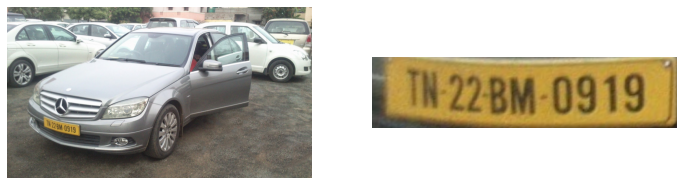

In [12]:
vehicle, LpImg, license_plate_string = lpr_process("dataset/images/plate4.jpeg")

# Display the result
fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle);
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0]);
print('Detected plate number: ' + license_plate_string)

As you can see, the result is not perfect, a 'B' has been mistaken for an '8', and a 'M' for an 'N'. It shows why there is always work to do to improve a model (still not too bad for  difficult plate seen from the side). But that's another story...

# Processing a set of images
Now that we have functions that we can directly call to do the processing, let's do this on all the test images that we have!

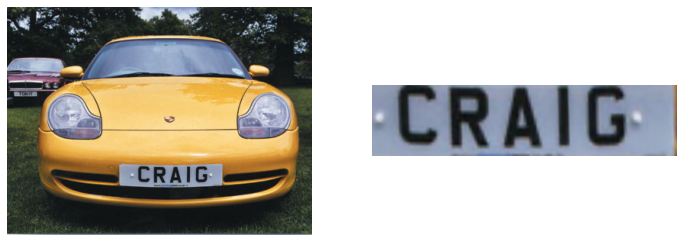

Detected plate number: CPAG
-------------------------------------


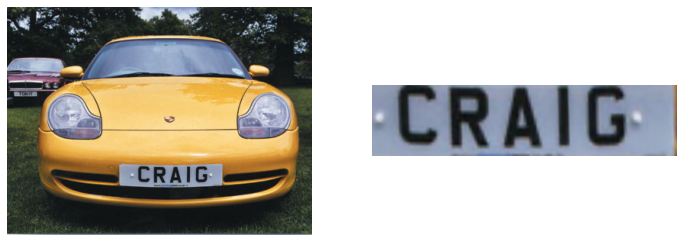

Detected plate number: CPAG
-------------------------------------


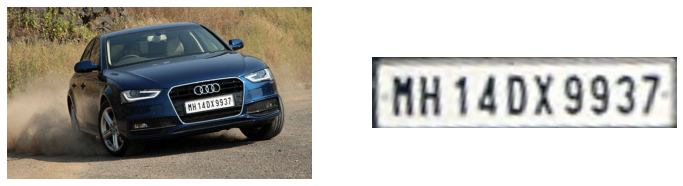

Detected plate number: MH1ADX9937
-------------------------------------


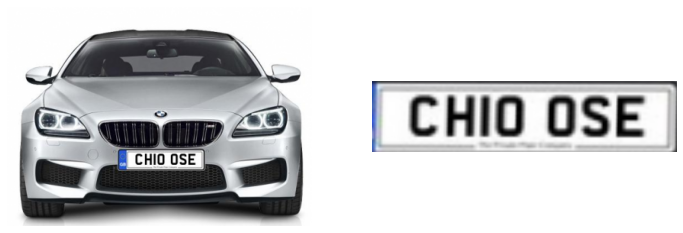

Detected plate number: CH00SE
-------------------------------------


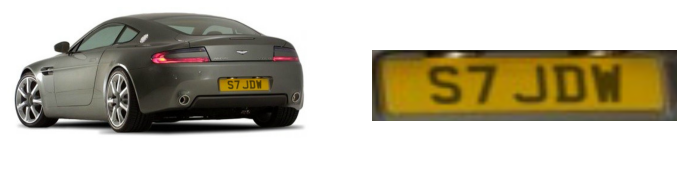

Detected plate number: S7JDV
-------------------------------------


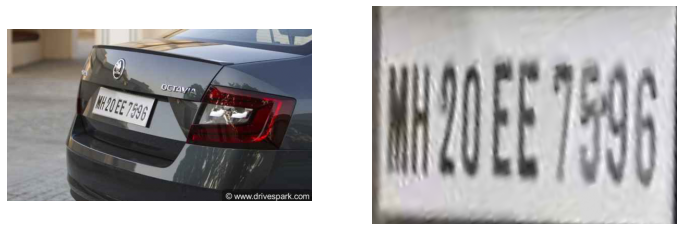

Detected plate number: Not able to read license plate
-------------------------------------


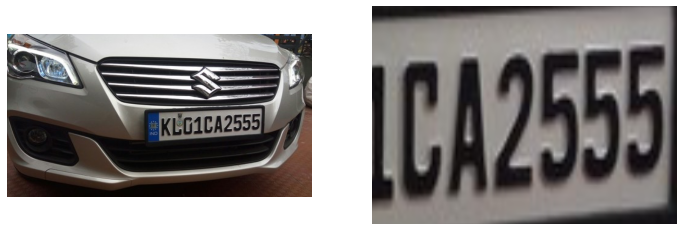

Detected plate number: CA2W555
-------------------------------------


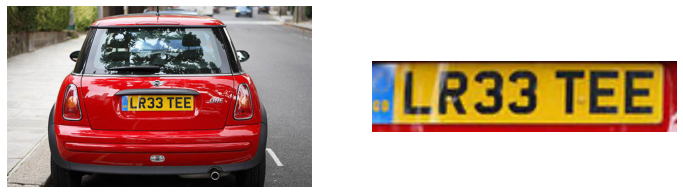

Detected plate number: UP33TEE
-------------------------------------


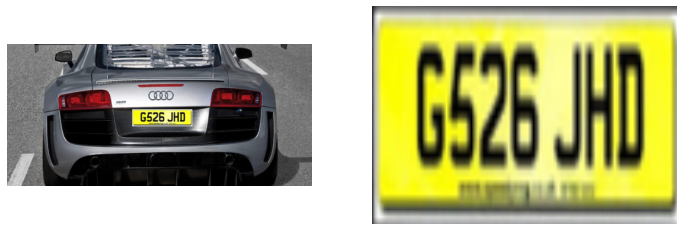

Detected plate number: Not able to read license plate
-------------------------------------


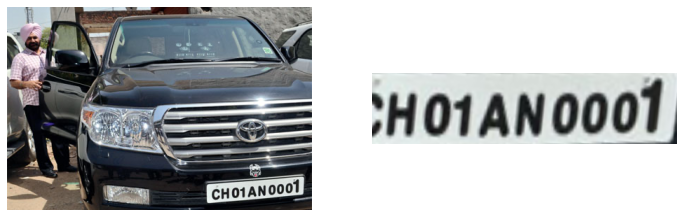

Detected plate number: HO1ANOOO1
-------------------------------------


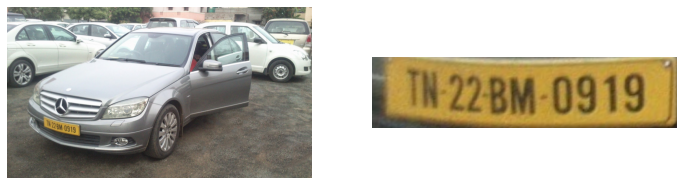

Detected plate number: TN228N0919
-------------------------------------


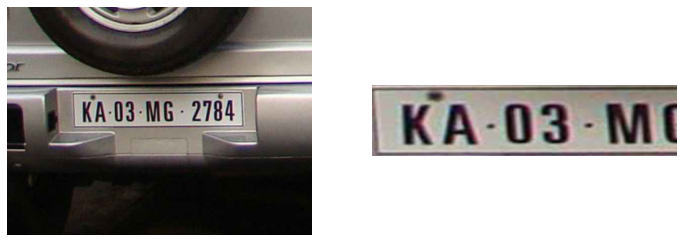

Detected plate number: KA03U
-------------------------------------


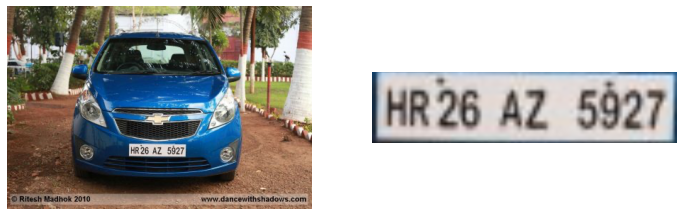

Detected plate number: HRAZ597
-------------------------------------


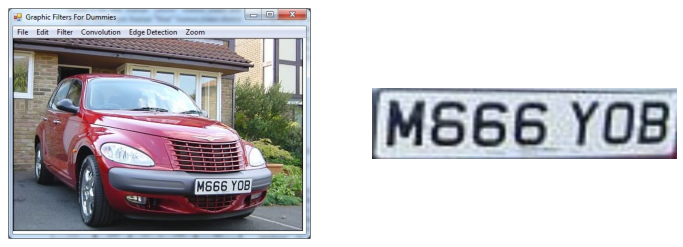

Detected plate number: N666Y0B
-------------------------------------


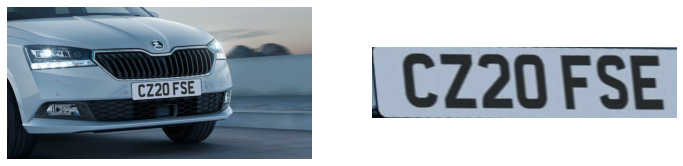

Detected plate number: CZ20FSE
-------------------------------------


In [11]:
%matplotlib inline
images_path = 'dataset/images'
for filename in os.listdir(images_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        vehicle, LpImg, license_plate_string = lpr_process(os.path.join(images_path, filename))
        # Display the result
        fig = plt.figure(figsize=(12,6))
        fig.add_subplot(1,2,1)
        plt.axis(False)
        plt.imshow(vehicle);
        fig.add_subplot(1,2,2)
        plt.axis(False)
        plt.imshow(LpImg[0]);
        plt.show()
        print('Detected plate number: ' + license_plate_string)
        print('-------------------------------------')

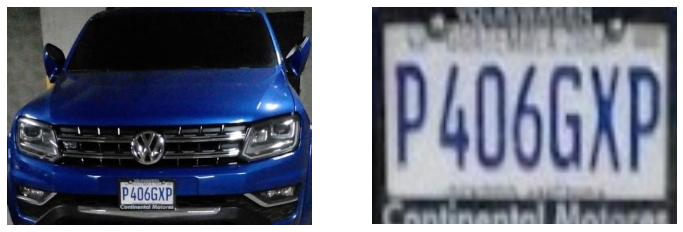

Detected plate number: P406GXP
-------------------------------------


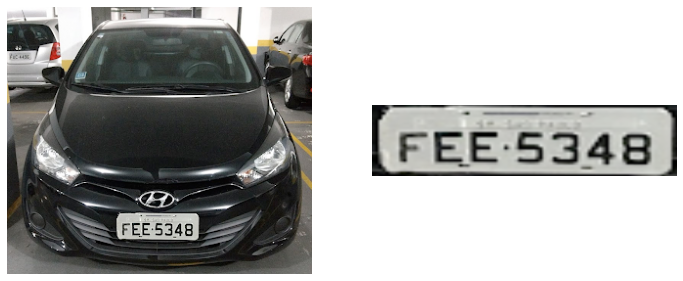

Detected plate number: FEE5348
-------------------------------------


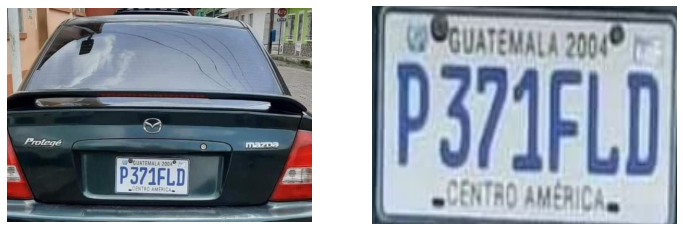

Detected plate number: P371FLD
-------------------------------------


In [13]:
#mag cell
%matplotlib inline
images_path = 'test/'
for filename in os.listdir(images_path):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        vehicle, LpImg, license_plate_string = lpr_process(os.path.join(images_path, filename))
        #print("vehicle", vehicle) #mag
        ##plt.imshow(vehicle); #mag
        #print("LpImg", LpImg) #mag
        ##print("license_plate_string: ", license_plate_string) #mag
        
        # Display the result
        fig = plt.figure(figsize=(12,6))
        fig.add_subplot(1,2,1)
        plt.axis(False)
        plt.imshow(vehicle);
        fig.add_subplot(1,2,2)
        plt.axis(False)
        plt.imshow(LpImg[0]);
        plt.show()
        print('Detected plate number: ' + license_plate_string)
        print('-------------------------------------')